Important Note: a lot of this code is directly copied or heavily based on the [pyPESTO source code](https://github.com/ICB-DCM/pyPESTO/tree/main/pypesto/objective/roadrunner)

In [1]:
import numpy as np
import pandas as pd
import petab
import pypesto.objective
import pypesto.optimize as optimize
import pypesto.objective.roadrunner as pypesto_rr
import pypesto.sample as sample
import pypesto.visualize as visualize
import pypesto.profile as profile
from IPython.display import Markdown, display
from pprint import pprint
#from modelproblem import ModelProblem

np.random.seed(1)

model_name = "Raia_CancerResearch2011"

#modprob = ModelProblem(model_name)

In [2]:
petab_yaml = f"./{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto_rr.PetabImporterRR(petab_problem)
problem = importer.create_problem()

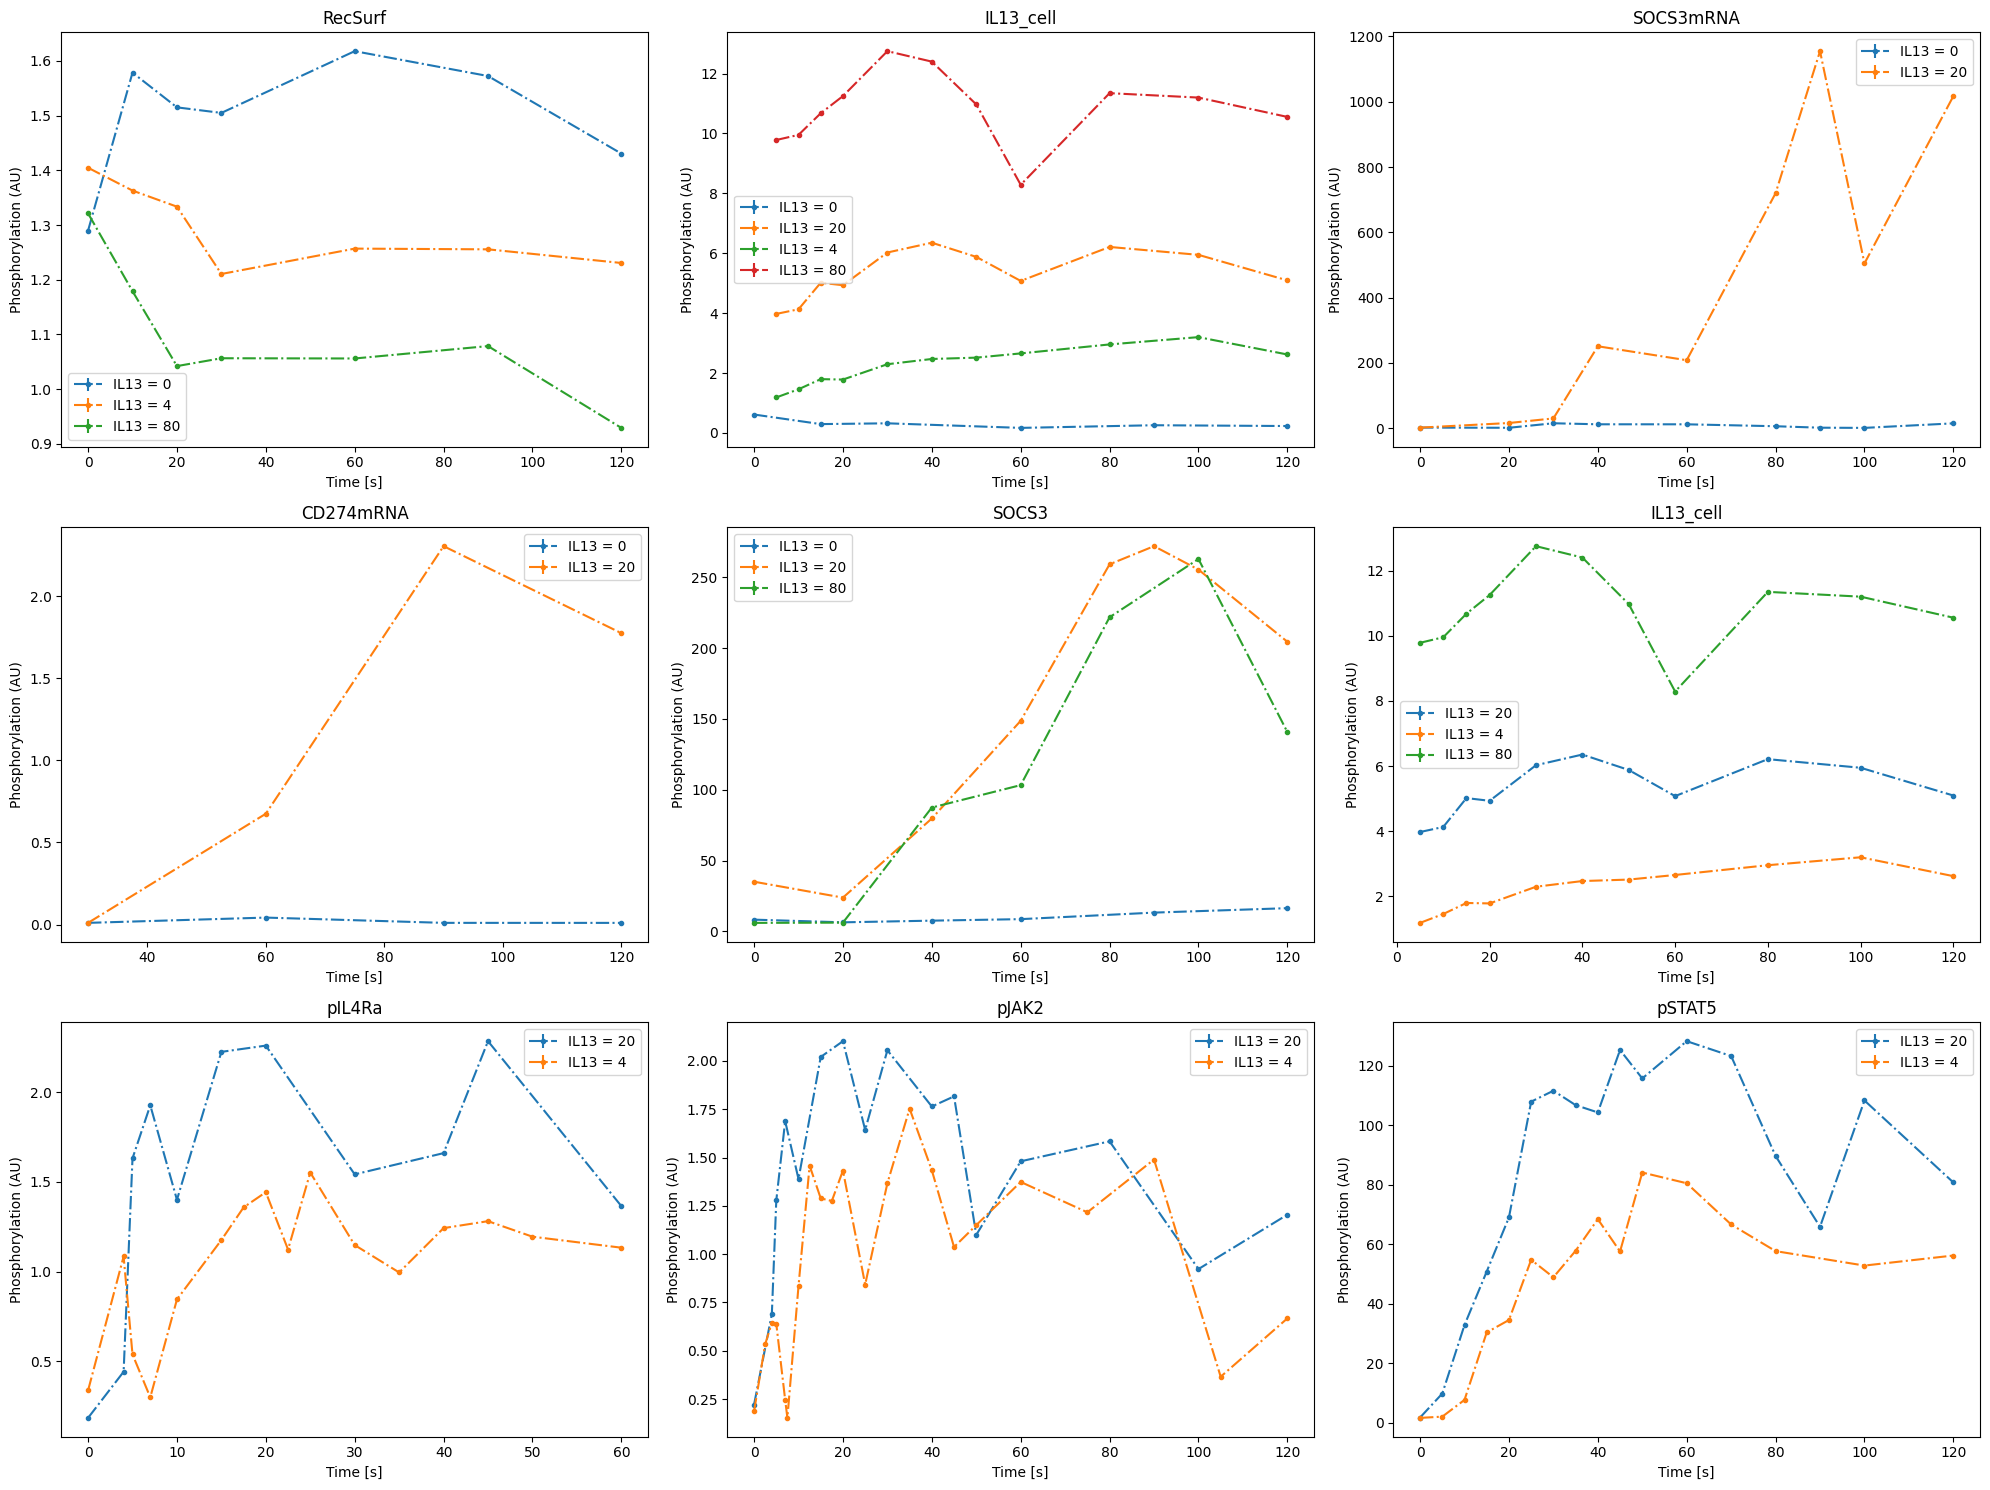

In [3]:
petab.visualize.plot_problem(petab_problem);

    time,   [Rec], [Rec_i], [IL13_Rec], [p_IL13_Rec], [p_IL13_Rec_i], [JAK2], [pJAK2], [STAT5], [pSTAT5], [SOCS3mRNA], [DecoyR], [IL13_DecoyR], [SOCS3], [CD274mRNA]
 [[    0,     1.3, 234.959,          0,            0,              0,    2.8,       0,     165,        0,           0,     0.34,             0,       0,           0],
  [  2.5, 1.37645, 234.883,          0,            0,              0,    2.8,       0,     165,        0,           0,     0.34,             0,       0,           0],
  [    5, 1.40862, 234.851,          0,            0,              0,    2.8,       0,     165,        0,           0,     0.34,             0,       0,           0],
  [   10, 1.42789, 234.832,          0,            0,              0,    2.8,       0,     165,        0,           0,     0.34,             0,       0,           0],
  [   20, 1.43189, 234.828,          0,            0,              0,    2.8,       0,     165,        0,           0,     0.34,             0,       0,           0],


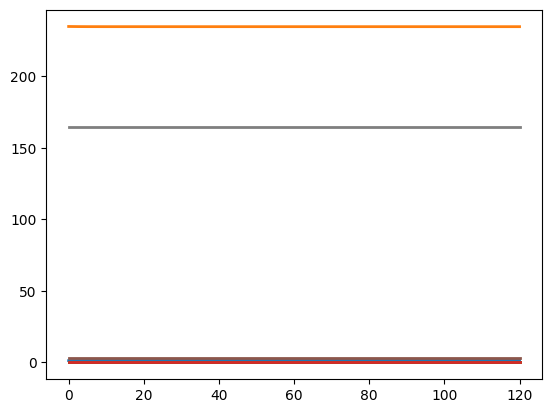

In [4]:
# direct simulation of the model using roadrunner
sim_res = problem.objective.roadrunner_instance.simulate(
    times=[0, 2.5, 5, 10, 20, 50, 120]
)
pprint(sim_res)
problem.objective.roadrunner_instance.plot();

In [5]:
ret = problem.objective(
    petab_problem.get_x_nominal(fixed=False,scaled=True),
    mode="mode_fun",
    return_dict=True,
)
pprint(ret)

{'fval': 78454.29892641956,
 'llh': -78454.29892641956,
 'simulation_results': {'model1_data1':     time, observable_CD274mRNA, observable_IL13_cell, observable_RecSurf, observable_SOCS3, observable_SOCS3mRNA
 [[    0,                    0,                    0,                1.3,                0,                    0],
  [   10,                    0,                    0,            1.42794,                0,                    0],
  [   15,                    0,                    0,            1.43134,                0,                    0],
  [   20,                    0,                    0,            1.43194,                0,                    0],
  [   30,                    0,                    0,            1.43207,                0,                    0],
  [   40,                    0,                    0,            1.43207,                0,                    0],
  [   60,                    0,                    0,            1.43207,                0,          

In [6]:
optimizer = optimize.ScipyOptimizer()

solver_options = pypesto_rr.SolverOptions(
    relative_tolerance = 1e-6,
    absolute_tolerance = 1e-12,
    maximum_num_steps = 20000
)
engine = pypesto.engine.MultiProcessEngine()
problem.objective.solver_options = solver_options

Engine will use up to 24 processes (= CPU count).


In [7]:
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=10,  # usually a value >= 100 should be used
    engine=engine
)
display(Markdown(result.summary()))

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


## Optimization Result 

* number of starts: 10 
* best value: 687.5608530203806, id=3
* worst value: 1509.7690637187025, id=6
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 9.504s
	* Maximum execution time: 11.962s,	id=4
	* Minimum execution time: 6.266s,	id=1
* summary of optimizer messages:

  |   Count | Message                                              |
  |--------:|:-----------------------------------------------------|
  |       9 | STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT |
  |       1 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH      |

* best value found (approximately) 1 time(s)
* number of plateaus found: 0

A summary of the best run:

### Optimizer Result

* optimizer used: <ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>
* message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT 
* number of evaluations: 1080
* time taken to optimize: 11.242s
* startpoint: [-2.58133942  2.02493949  0.53858093 -0.73467772  1.31423463 -2.87562673
 -1.68656584  1.45913031 -2.20881326 -0.37288308 -2.14184192  0.57454529
 -3.03031146 -4.85082169 -4.02925235 -3.37365412  1.6318472  -1.95887062
 -4.46770815  1.17742424  0.13252967 -3.98936384  1.47592554 -2.71424919
 -3.52791839  2.79026831  0.58445799 -1.55802183 -2.8383339  -1.27432097
 -0.4440447  -4.11286959 -4.18426192 -0.84518541  1.83292355 -2.94344561
 -0.66752497  0.96509754 -3.3687502 ]
* endpoint: [-2.58133942  2.02493949  0.53858093 -0.73467772  1.31423561 -2.87589196
 -1.68656584  1.45939604 -2.20881326 -0.37288308 -2.14184192  0.57454529
 -3.03031146 -4.85082373 -4.02925235 -3.37365412  1.6318472  -1.95887062
 -4.46770815  0.61941165  0.13252967 -3.98936384  1.47592554  2.64523047
 -3.51559761  2.79026831 -0.25562448 -0.5007507   0.01971794 -0.01588184
 -0.4440447  -4.11286959 -4.18426192 -0.49820487  1.83292355  0.28241954
  2.034614    2.17046115 -3.3687502 ]
* final objective value: 687.5608530203806
* final gradient value: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.59383663e-04  0.00000000e+00 -6.48014979e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.68434192e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.49365982e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.12263639e+00
  2.80351744e-02  0.00000000e+00 -1.76845333e+01  3.77072409e+01
 -4.42689838e+01 -6.26467909e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.48309266e+00  0.00000000e+00  1.28258080e+01
  3.82215833e+01  2.61460402e+00  0.00000000e+00]


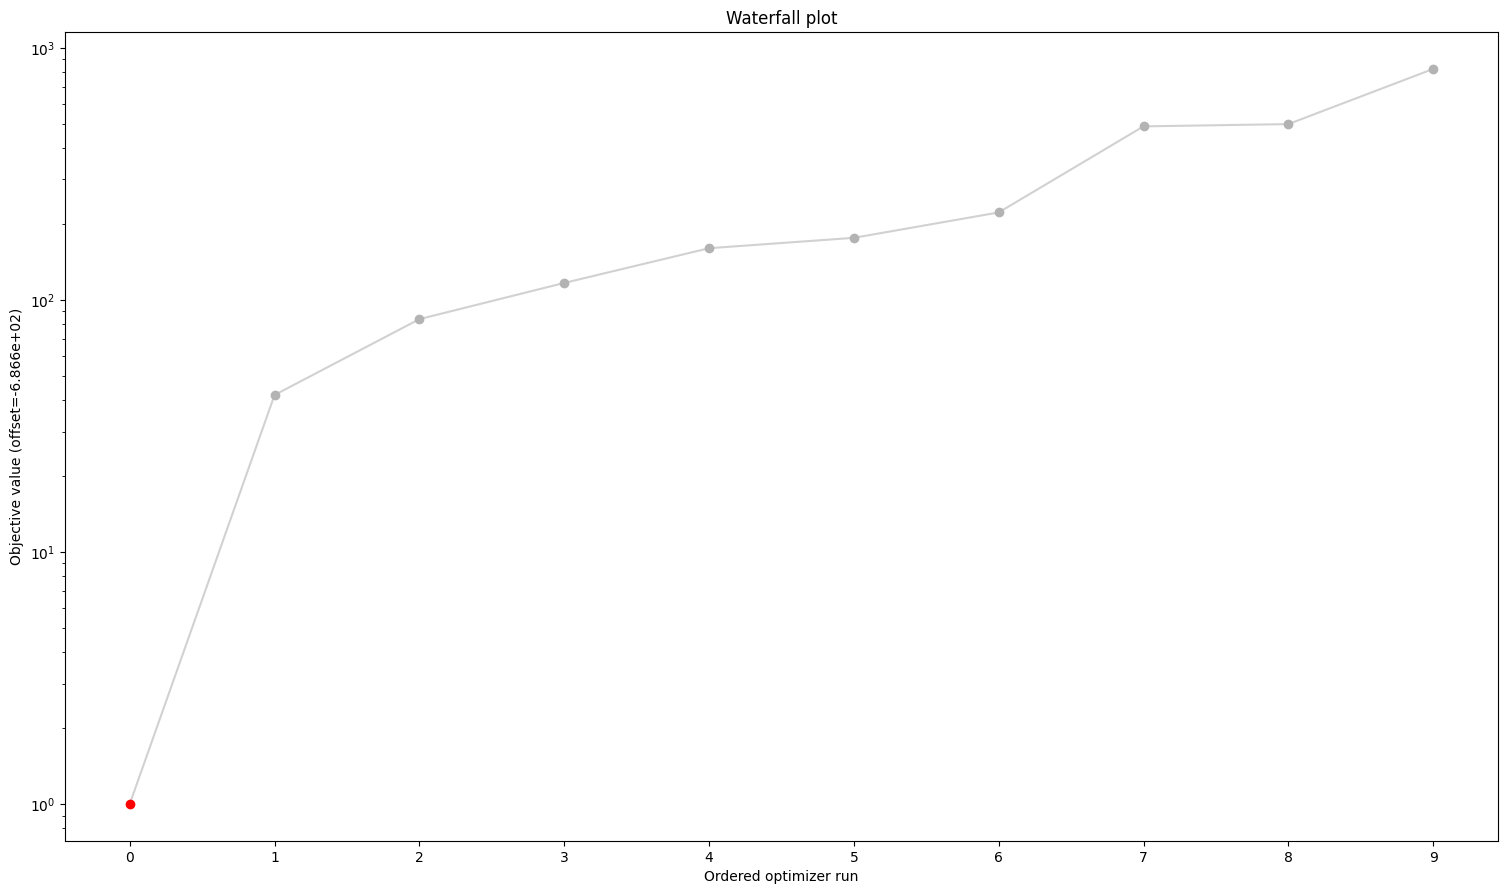

In [8]:
visualize.waterfall(result);

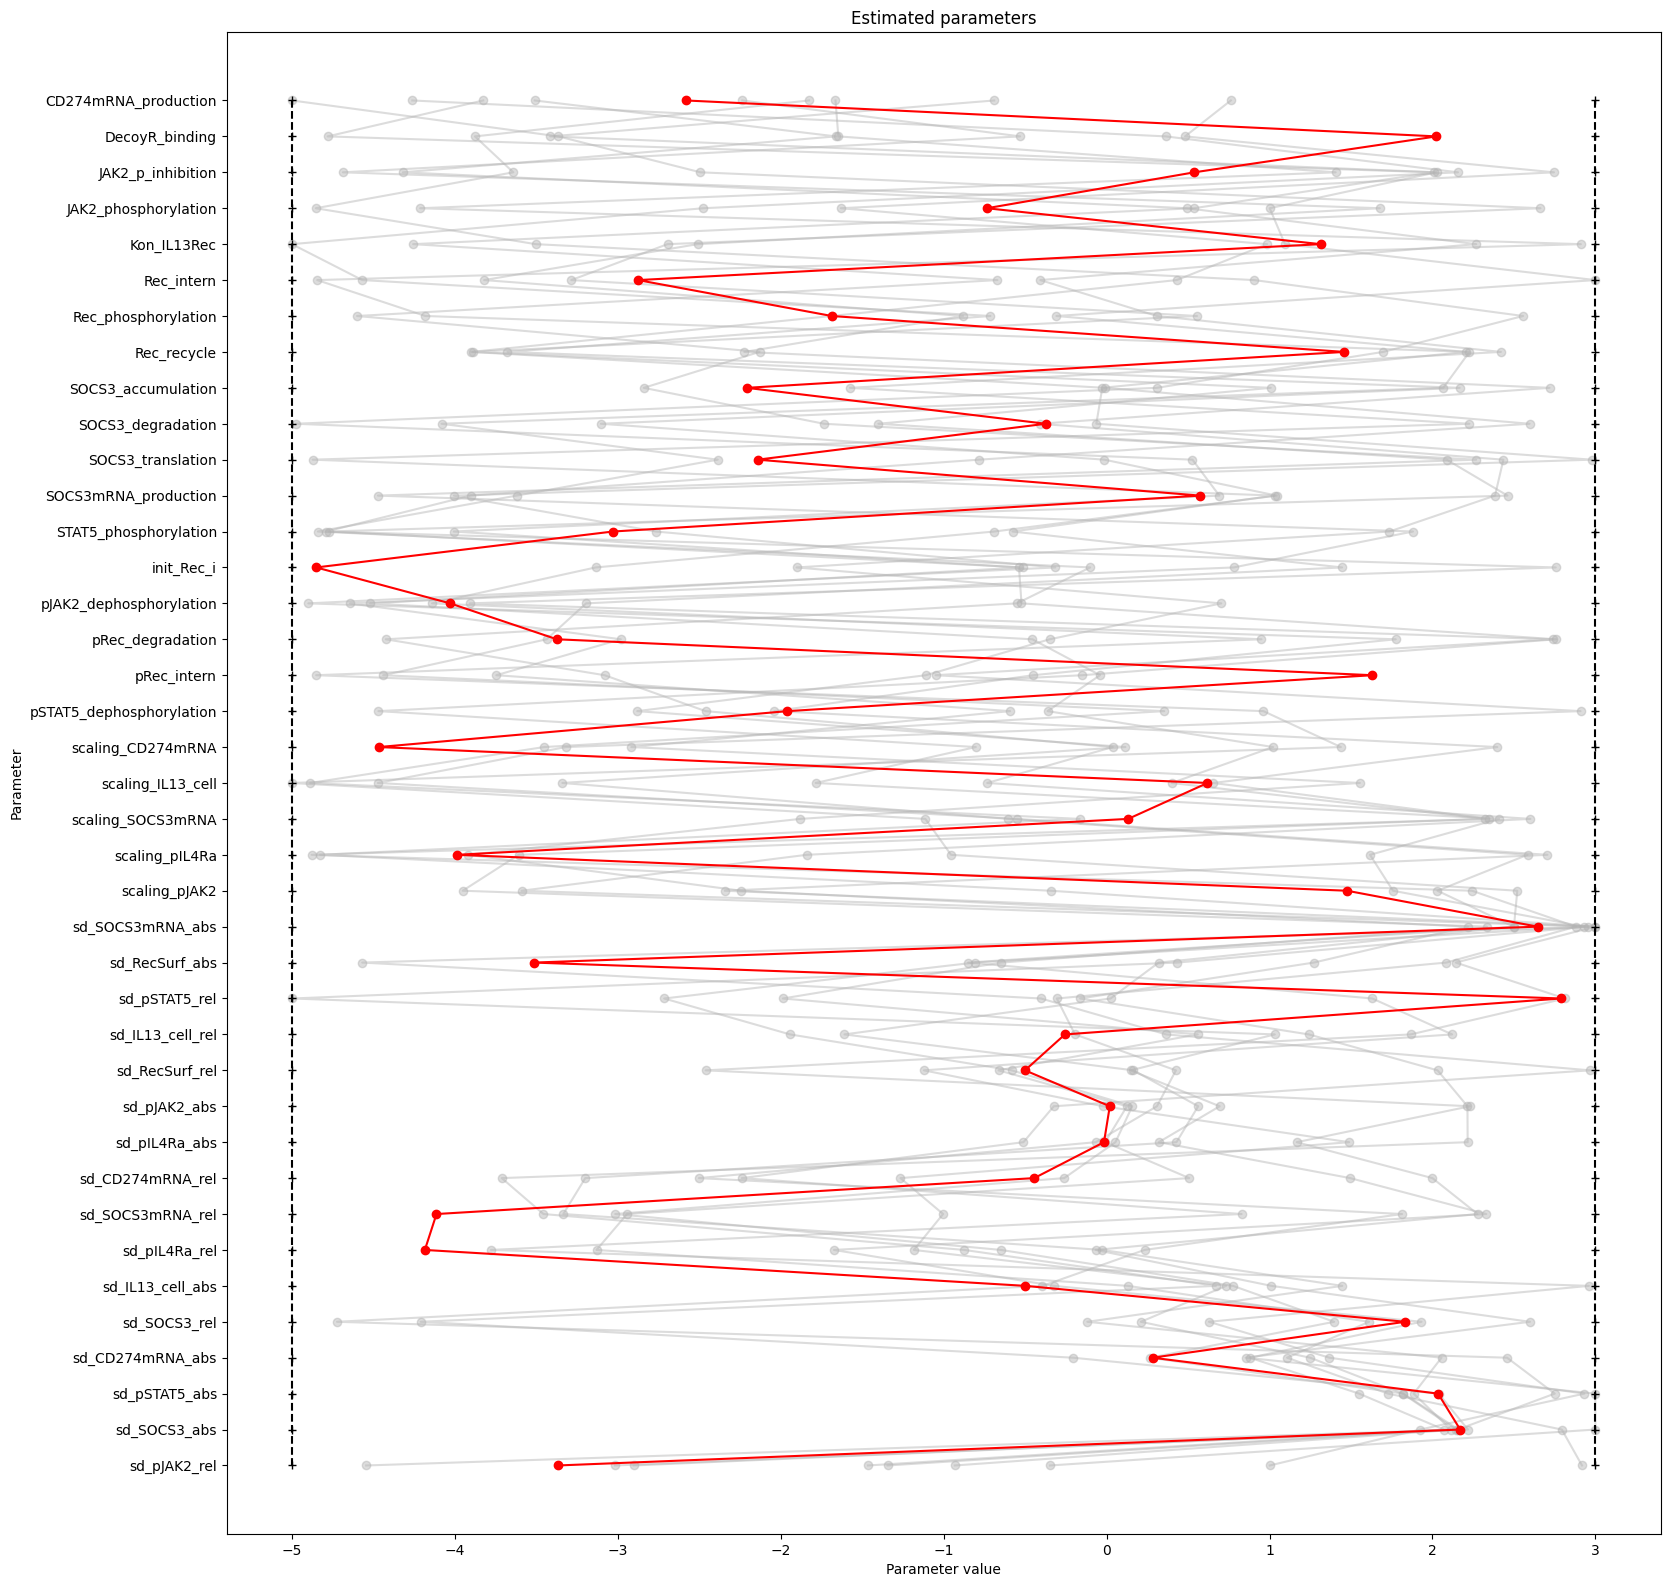

In [9]:
visualize.parameters(result);

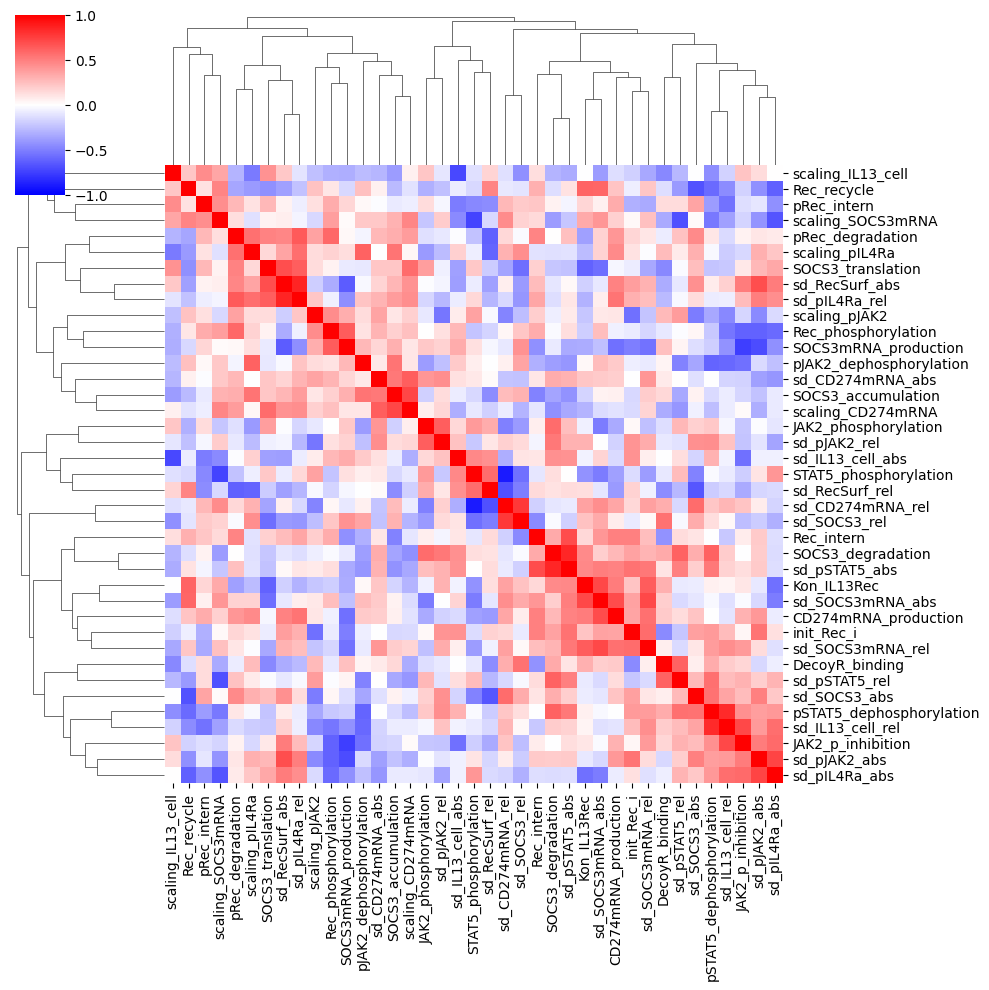

In [10]:
visualize.parameters_correlation_matrix(result);